# Representing Matrices Using Algebraic ZX-calculus

Implements automatic ZX diagram synthesis using the work from [arxiv:2110.06898](https://arxiv.org/abs/2110.06898).

In [1]:
import warnings
warnings.filterwarnings('ignore')
from discopy.quantum.zx import *
from discopy import tensor, Tensor, Dim
import numpy as np
from itertools import chain
import tensornetwork as tn
from math import log2

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
"""
Some helper functions on bits.
"""

def bitstring(x):
    return [int(b) for b in "{0:b}".format(x)]

def bitstring2(n, x):
    arr = [int(b) for b in '0' * n + "{0:b}".format(x)]
    return arr[-n:]

In [3]:
"""
Define the generators used in Algebraic ZX calculus.
"""

class Z(Spider):
    """ Z spider. """
    def __init__(self, n_legs_in, n_legs_out, phase=0):
        super().__init__(n_legs_in, n_legs_out, phase, name='Z')
        self.color = "green"

    @property
    def array(self):
        n, m = len(self.dom), len(self.cod)
        array = np.zeros(1 << (n + m), dtype=complex)
        array[0] = 1
        array[-1] = np.exp(1j * self.phase)
        return Tensor(Dim(2) ** n, Dim(2) ** m, array)

    
class ZBox(Spider):
    """ Green box. """
    def __init__(self, n_legs_in, n_legs_out, phase=0):
        super().__init__(n_legs_in, n_legs_out, phase, name='ZBox')
        self.color = "green"
        self.shape = 'rectangle'

    @property
    def array(self):
        n, m = len(self.dom), len(self.cod)
        array = np.zeros(1 << (n + m), dtype=complex)
        array[0] = 1
        array[-1] = self.phase
        return Tensor(Dim(2) ** n, Dim(2) ** m, array)


class X(Spider):
    """ X spider. """
    def __init__(self, n_legs_in, n_legs_out, phase=0):
        super().__init__(n_legs_in, n_legs_out, phase, name='X')
        self.color = "red"

    @property
    def array(self):
        assert self.phase in (0, 0.5)
        n, m = len(self.dom), len(self.cod)
        array = np.zeros(1 << (n + m), dtype=complex)
        bit = 1 if self.phase == 0.5 else 0
        for i in range(len(array)):
            parity = (bitstring(i).count(1) + bit) % 2
            array[i] = 1 - parity
        return Tensor(Dim(2) ** n, Dim(2) ** m, array)
       

class AND(Spider):
    """ AND spider. """
    def __init__(self, n_legs_in):
        super().__init__(n_legs_in, 1, name='AND')
        self.draw_as_spider = False
        self.drawing_name = 'AND'

    @property
    def array(self):
        n, m = len(self.dom), len(self.cod)
        array = np.zeros(1 << (n + m), dtype=complex)
        for i in range(0, (1 << (n + m)) - 2, 2):
            array[i] = 1
        array[-1] = 1
        return Tensor(Dim(2) ** n, Dim(2) ** m, array)

    def __repr__(self):
        return f'{self.name}({self.dom})'


class Tri(Spider):
    """ Triangle gate. """
    def __init__(self):
        super().__init__(1, 1, name='T')
        self.color = 'yellow'
        self.shape = 'triangle_up'

    @property
    def array(self):
        return Tensor(Dim(2), Dim(2), [[1, 0], [1, 1]])

    def __repr__(self):
        return self.name

T = Tri()

In [4]:
"""
Efficient evaluation of algebraic ZX diagrams
using a functor + Google's tensornetwork library.
"""

def f_ob(ob):
    return Dim(2) ** len(ob)

def f_ar(box):
    return tensor.Box(box.name, f_ob(box.dom), f_ob(box.cod), box.array)

f = Functor(ob=f_ob, ar=f_ar, ar_factory=tensor.Diagram)

def eval(diagram):
    d = Functor(ob=f_ob, ar=f_ar, ar_factory=tensor.Diagram)(diagram)
    t = d.eval(contractor=tn.contractors.auto)
    dim = 1 << len(diagram.dom)
    return t.array.astype(float).reshape(dim, dim).transpose()

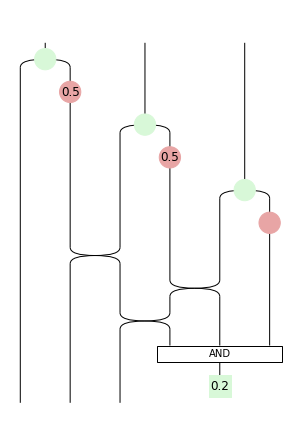

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [5]:
"""
Verifying Theorem 3.1. (Row multiplication)
"""

def row_mul(n, i, a):
    # TODO add boundary checks
    bits = bitstring2(n, i)
    diagram = Id().tensor(*[Z(1, 2) >> Id(1) @ X(1, 1, (1 ^ b) / 2) for b in bits])
    perm = chain(range(0, 2 * n, 2), range(1, 2 * n, 2))
    diagram = diagram.permute(*perm)
    return diagram >> Id(n) @ (AND(n) >> ZBox(1, 0, a))

diagram = row_mul(3, i=1, a=0.2)
diagram.draw(figsize=(4, 6), nodesize=5)
diagram.draw(figsize=(4, 6), nodesize=5, path='mul.pdf')

eval(diagram)

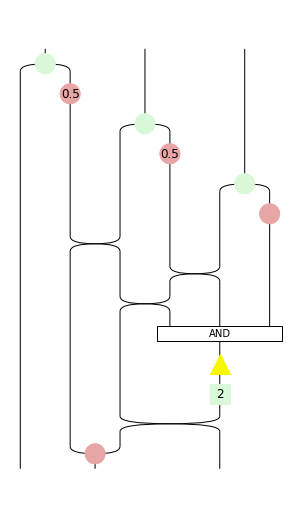

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 2., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
"""
Verifying Theorem 3.4. (Row addition)
"""

def row_add(n, i, j, a):
    bits_i = bitstring2(n, i)
    bits_j = bitstring2(n, j)
    diagram1 = Id().tensor(*[Z(1, 2) >> Id(1) @ X(1, 1, (1 - b) / 2) for b in bits_i])
    perm = chain(range(0, 2 * n, 2), range(1, 2 * n, 2))
    diagram1 = diagram1.permute(*perm)
    
    perm = []
    app = []
    off = 0
    diagram2 = Id()
    for x in range(n):
        perm.append(x+off)
        if bits_i[x] ^ bits_j[x]:
            app.append(x + off + 1)
            off += 1
            diagram2 @= X(1, 2)
        else:
            diagram2 @= Id(1)
    perm += app
    diagram1 = diagram1 >> Id(n) @ (AND(n) >> T >> ZBox(1, len(app), a))
    diagram2 = diagram2.permute(*perm)
    return diagram1 >> diagram2.dagger()

diagram = row_add(3, i=1, j=3, a=2)
diagram.draw(figsize=(4, 7), nodesize=5)
diagram.draw(figsize=(4, 7), nodesize=5, path='add.pdf')

eval(diagram)

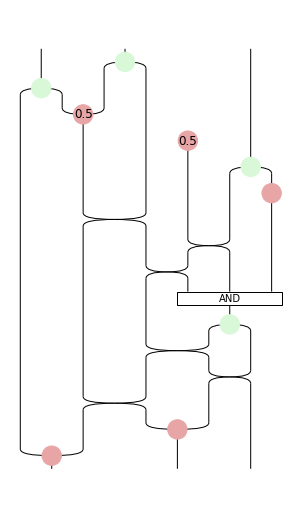

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])

In [7]:
"""
Verifying Theorem 3.7. (Row switching)
"""

def row_swap(n, i, j):
    bits_i = bitstring2(n, i)
    bits_j = bitstring2(n, j)
    diagram1 = Id()

    mis = []
    for x, (b1, b2) in enumerate(zip(bits_i, bits_j)):
        if b1 ^ b2:
            mis.append(x)

    assert mis
    diagram0 = Id(n - mis[-1] - 1) @ Z(1, len(mis)) @ Id(mis[-1])
    for x, pos in enumerate(mis):
        diagram0 = diagram0.permute(mis[-1], *range(pos + x + 1, mis[-1]))
    for x, (b1, b2) in enumerate(zip(bits_i, bits_j)):
        if b1 ^ b2 and x != mis[-1]:
            diagram1 @= Z(1, 2) @ Id(1) >> Id(1) @ X(2, 1, (1 ^ b1 ^ bits_i[mis[-1]]) / 2)
        elif x == mis[-1]:
            diagram1 @= Id(1) @ X(0, 1, 0.5)
        else:
            diagram1 @= Z(1, 2) >> Id(1) @ X(1, 1, (1 ^ b1) / 2)
    perm = chain(range(0, 2 * n, 2), range(1, 2 * n, 2))
    diagram1 = diagram1.permute(*perm)
    
    perm = []
    app = []
    off = 0
    diagram2 = Id()
    for x in range(n):
        perm.append(x+off)
        if bits_i[x] ^ bits_j[x]:
            app.append(x + off + 1)
            off += 1
            diagram2 @= X(1, 2)
        else:
            diagram2 @= Id(1)
    perm += app
    diagram1 = diagram1 >> Id(n) @ (AND(n) >> Z(1, len(app)))
    diagram2 = diagram2.permute(*perm)
    return diagram0 >> diagram1 >> diagram2.dagger()

diagram = row_swap(3, i=1, j=7)
diagram.draw(figsize=(4, 7), nodesize=5)
diagram.draw(figsize=(4, 7), nodesize=5, path='swap.pdf')


eval(diagram)

In [8]:
"""
Swapping row i with j is equal to swapping row j with i
"""
row_swap(3, 3, 7) == row_swap(3, 7, 3)

True

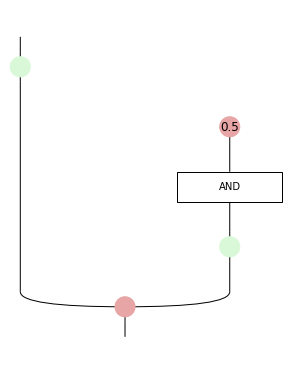

array([[0., 1.],
       [1., 0.]])

In [9]:
"""
Swapping 0 with 1 for 1 qubit gives you the NOT gate
"""

diagram = row_swap(1, 1, 0)
diagram.draw(figsize=(4, 5), nodesize=3)

eval(diagram)

In [10]:
"""
Gaussian Elimination
"""

def gauss(mat):
    # TODO for non-invertible
    n, m = len(mat), len(mat[0])
    if n != m:
        raise NotImplementedError
    log_n = int(log2(n))
    diagram = Id(log_n)
    for i in range(n):
        j = i
        while j < n and mat[j][i] == 0:
            j += 1
        if j == n:
            raise Exception('Not invertible')
        # row swap
        if i != j:
            mat[i], mat[j] = mat[j], mat[i]
            diagram <<= row_swap(log_n, i, j)
        # row scale
        s = mat[i][i]
        for j in range(i, n):
            mat[i][j] /= s
        diagram <<= row_mul(log_n, i, s)
        for j in range(i + 1, n):
            if mat[j][i] != 0:
                s = mat[j][i]
                for k in range(i, n):
                    mat[j][k] -= s * mat[i][k]
                diagram <<= row_add(log_n, i, j, s)
    # back sub
    for i in range(1, n)[::-1]:
        j = i - 1
        while j >= 0:
            if mat[j][i] != 0:
                s = mat[j][i]
                for k in range(n):
                    mat[j][k] -= s * mat[i][k]
                diagram <<= row_add(log_n, i, j, s)
            j -= 1
    return mat, diagram

result:
[[0. 2.]
 [3. 1.]]


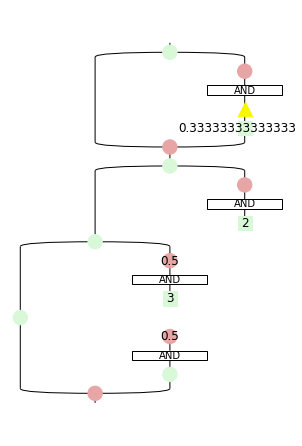

In [11]:
"""
2 x 2 example
"""
m, d = gauss([[0, 2], [3, 1]])
print('result:')
print(eval(d))
d.draw(figsize=(4, 6), nodesize=3)

result:
[[1. 2.]
 [3. 4.]]


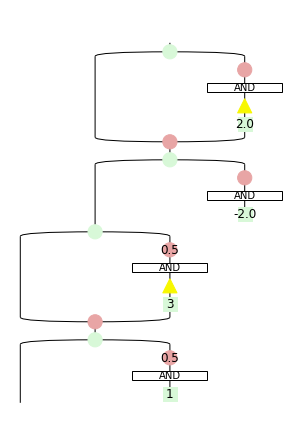

In [12]:
"""
2 x 2 example
"""

m, d = gauss([[1, 2], [3, 4]])
print('result:')
print(eval(d))
d.draw(figsize=(4, 6), nodesize=3)

result:
[[1. 2. 3. 4.]
 [2. 2. 4. 4.]
 [3. 7. 2. 0.]
 [9. 9. 9. 9.]]


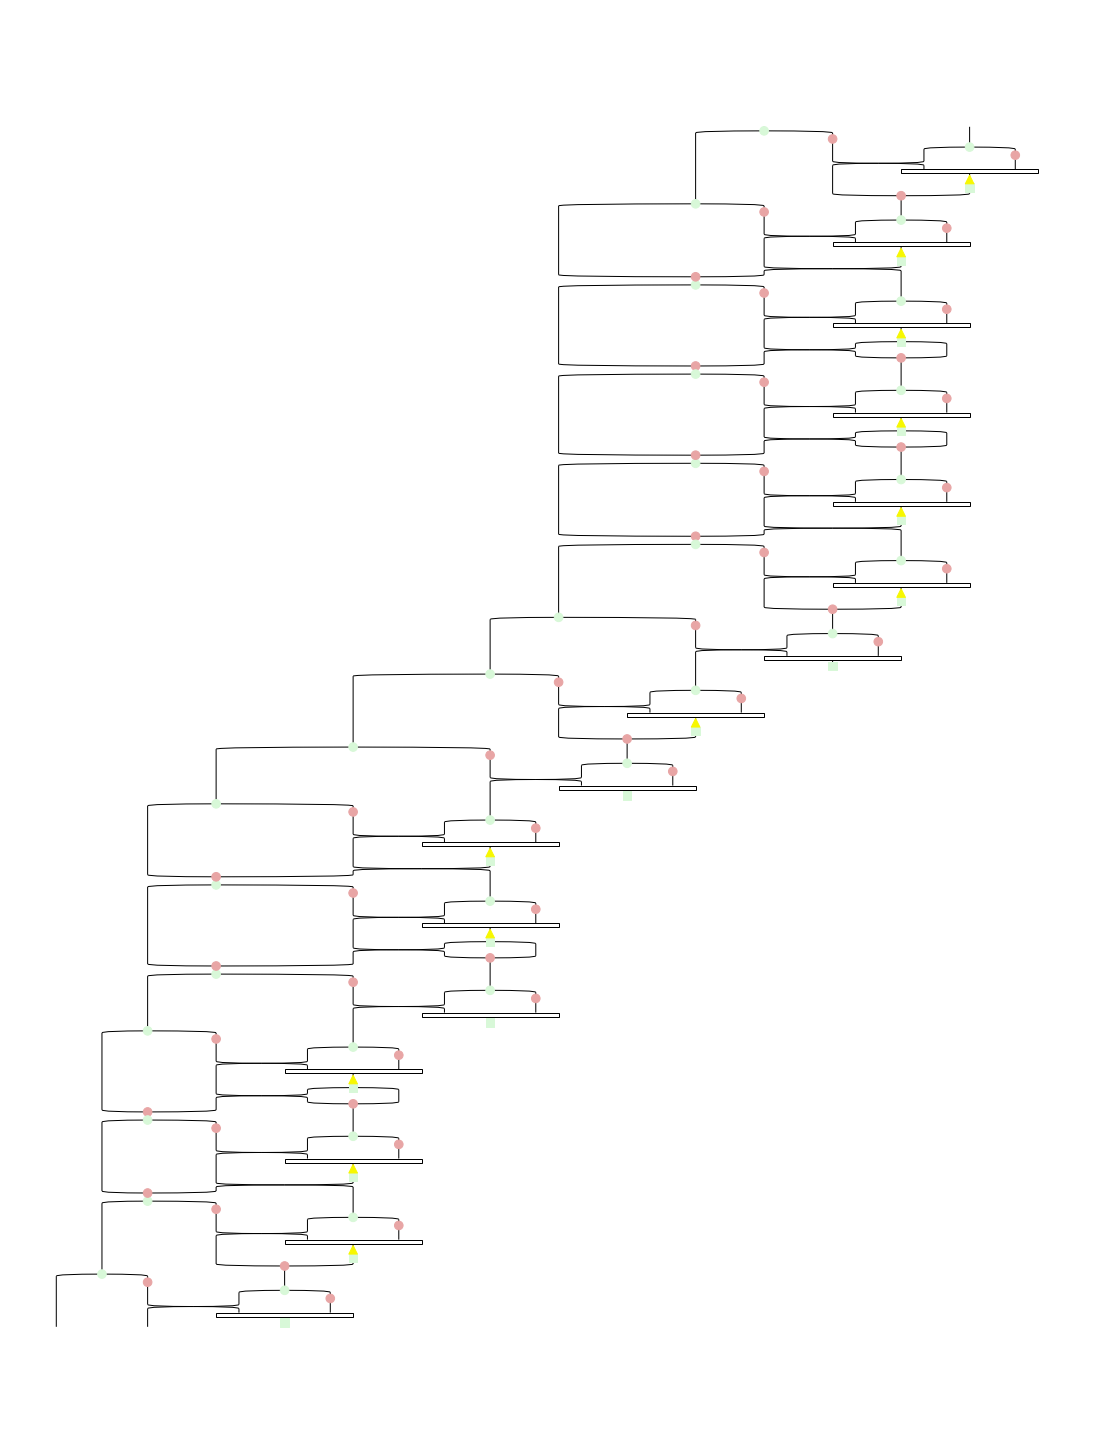

In [13]:
"""
4 x 4 example
"""

m, d = gauss([[1, 2, 3, 4], [2, 2, 4, 4], [3, 7, 2, 0], [9, 9, 9, 9]])
print('result:')
print(eval(d))
d.draw(figsize=(15, 20), draw_box_labels=False, nodesize=3)